/home/ianjefab/ipykernel_477885/718692800.py:87: RuntimeWarning: invalid value encountered in divide
  weights /= np.sum(weights, axis=0, keepdims=True) # After normalization, each column sums to 1


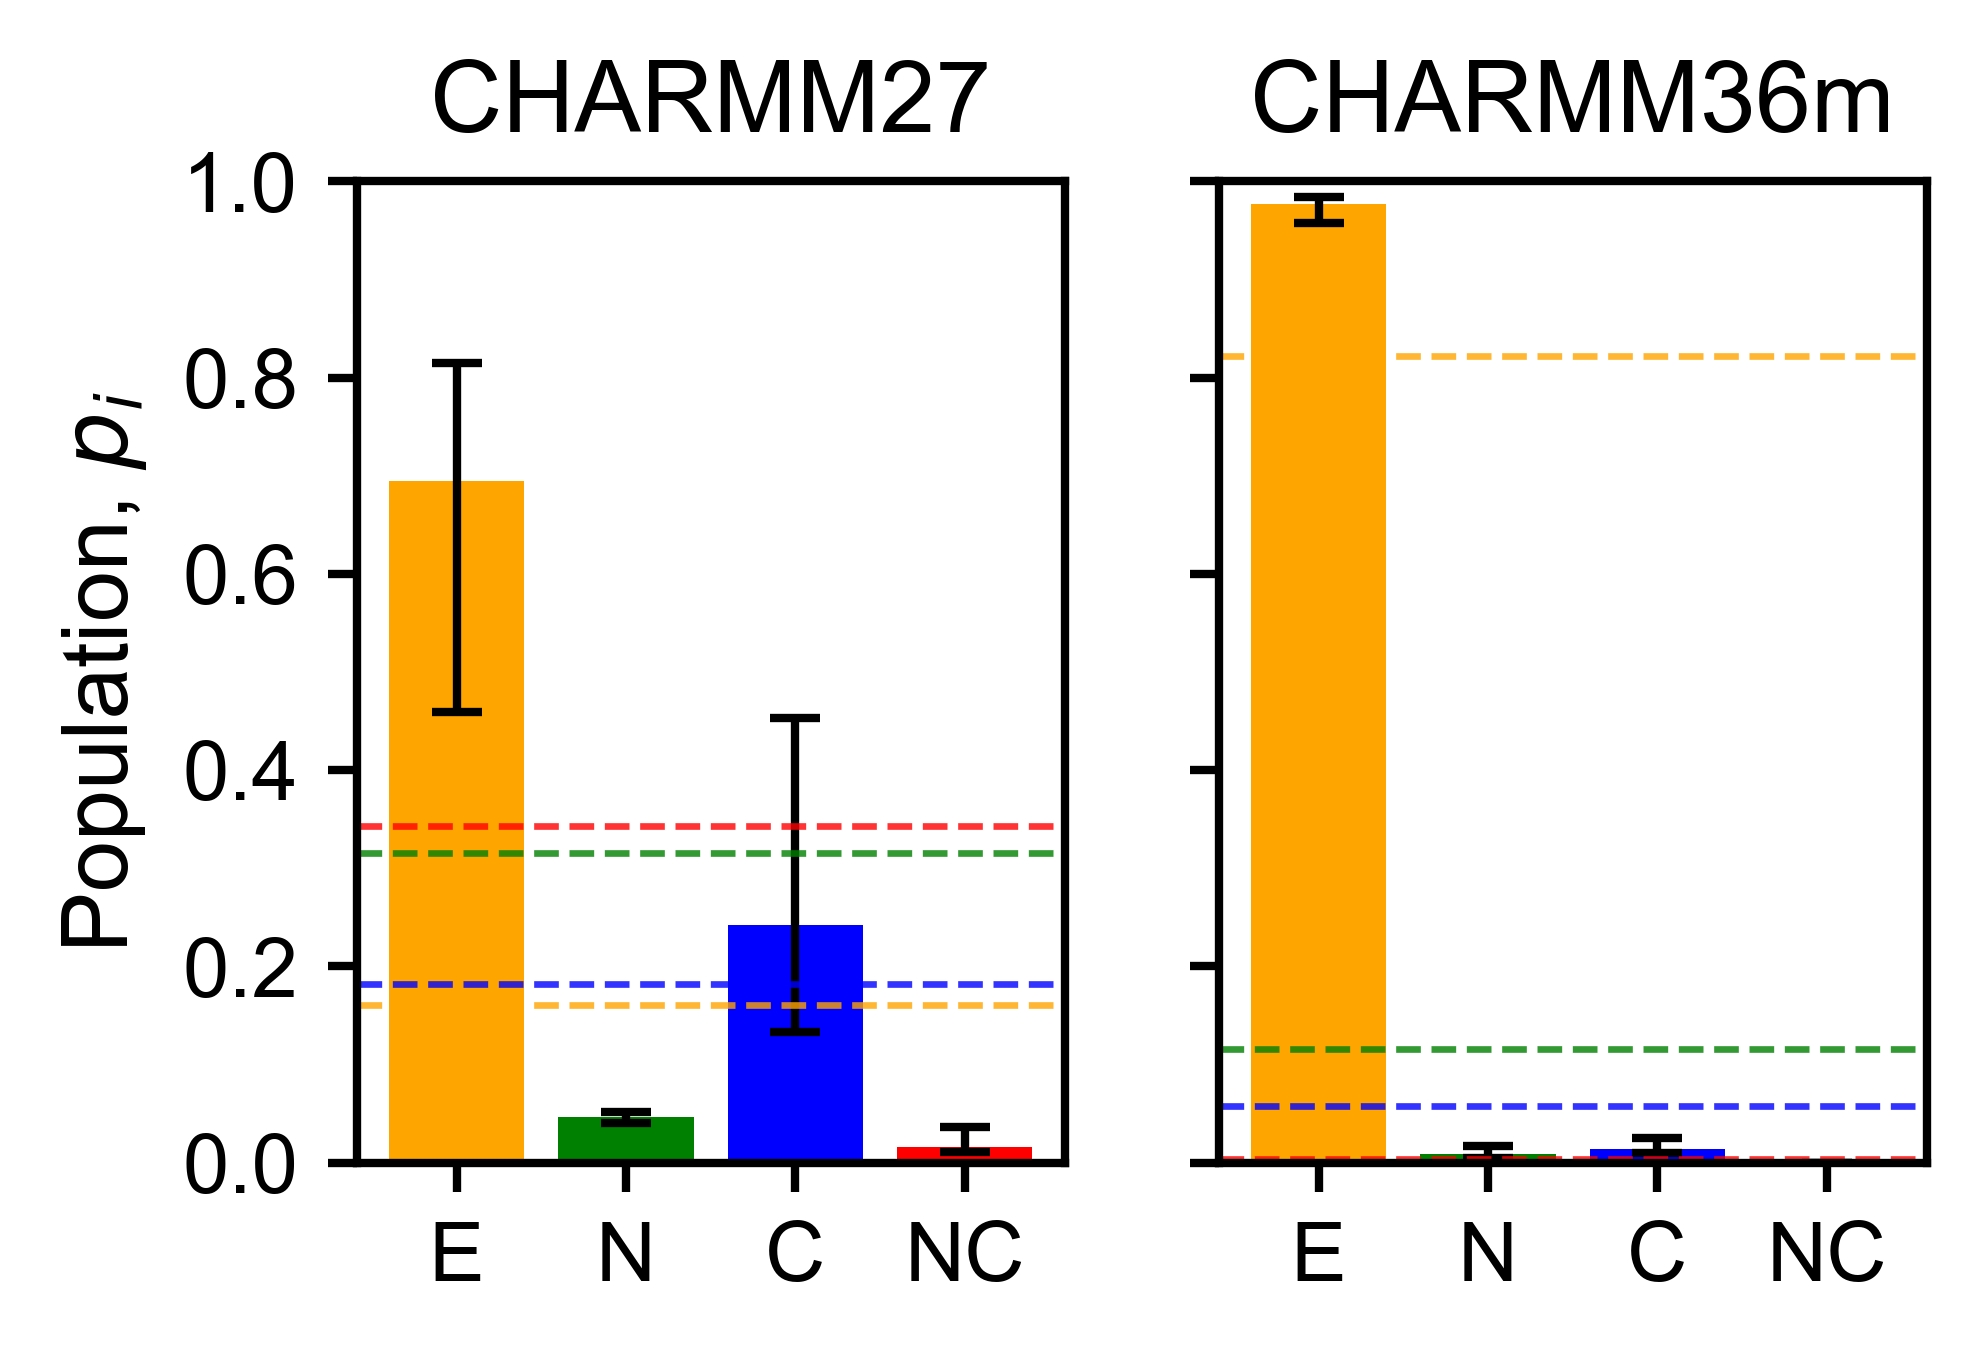

In [1]:
### PLOTS GLOBAL REFINEMENT (FIG 5) IN MAIN TEXT ###
### 1 Aug 2025 ###

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# Paths
BASE_DIR = Path('../data')
ERROR_DIR = BASE_DIR / 'error_data' / 'overlap_full'
PROP_DIR = BASE_DIR / 'prop_array'

# Data Specifications
FORCE_FIELDS = ['CHARMM27_TIP3P', 'CHARMM36m_TIP3P']
ISOTOPES = ['G3', 'G3+', 'G5+', 'G5+G3', 'V1', 'V1G3V4', 'V1V4', 'V4', 'WT']

# State definitions
STATE_KEYS = ['C', 'E', 'NC', 'N']
STATE_PLOT_ORDER = ['E', 'N', 'C', 'NC']
STATE_COLORS = {'E': 'orange', 'N': 'green', 'C': 'blue', 'NC': 'red'}

# Analysis Parameters
SHIFT_VALUES = [-2, 0, 2]
ESS_TARGET = 100
THETA_RANGE = np.logspace(-1, 4, 1000)

# Plotting Specifications
FIGURE_SIZE = (3.25, 2.2)
DPI = 600

# -----------------------------------------------------------------------------
# DATA LOADING
# -----------------------------------------------------------------------------

# Loads the proportions array (simple loading function)
def load_proportions(force_field):
    """Load state proportions for given force field."""
    filepath = PROP_DIR / force_field / f'proportions_array_0100ps_{force_field}_PAPER.npy'
    return np.load(filepath)

# Sums error values across all 9 isotopologues
def load_combined_error_data(force_field, shift): # Each data array has shape: (5000 segments, 1000 theta values)
    """Load and sum error data across all isotopes for given shift."""
    combined_error = None
    
    for isotope in ISOTOPES:
        # Each data array has shape: (n_frames, n_theta_values)
        filename = f'error_overlap_{isotope}_{force_field}_ch27_{shift}.npy'
        filepath = ERROR_DIR / filename
        
        if filepath.exists():
            data = np.load(filepath)
            if combined_error is None:
                combined_error = data
            else:
                combined_error = combined_error + data
    
    return combined_error # shape (5000, 1000)

# -----------------------------------------------------------------------------
# ANALYSIS
# -----------------------------------------------------------------------------

def compute_ess(weights):
    """Compute effective sample size from weights."""
    # Input: weights shape (5000, 1000)
    sum_weights = np.sum(weights, axis=0) # Shape: (1000,) - sum down each column
    sum_weights_squared = np.sum(weights**2, axis=0) # Shape: (1000,) - sum of squares down each column

    # ESS formula: (Σw)**2 / (Σw**2) applied to each of the 1000 theta columns
    return np.divide(sum_weights**2, sum_weights_squared, 
                    out=np.full_like(sum_weights, np.nan), 
                    where=sum_weights_squared != 0) # Shape: (1000,) - one ESS per \theta

def find_best_theta_index(ess_array):
    """Find index for target ESS."""
    valid_ess = np.nan_to_num(ess_array, nan=-np.inf)
    return np.argmin(np.abs(valid_ess - ESS_TARGET))

def compute_reweighted_populations(error, proportions):
    """Calculate reweighted populations and ESS across theta range."""
    weights = np.exp(-error) # Shape: (5000, 1000) 
    weights /= np.sum(weights, axis=0, keepdims=True) # After normalization, each column sums to 1
    
    # proportions[:, idx:idx+1] shape: (5000, 1) - keeps 2D for broadcasting
    # Broadcasting: (5000, 1) * (5000, 1000) → (5000, 1000) 
    # np.sum(axis=0) → (1000,) - weighted average for each theta value
    reweighted_populations = { # idx: 0,1,2,3 for C,E,NC,N
        state: np.sum(proportions[:, idx:idx+1] * weights, axis=0)
        for idx, state in enumerate(STATE_KEYS)
    }
    
    ess = compute_ess(weights) # Shape: (1000,)
    return reweighted_populations, ess 
    # reweighted_populations is dictionary structure:
    # reweighted_populations = {
    #   'C': array of shape (1000,),   # Population of state C for each of 1000 theta values
    #   'E': array of shape (1000,),   # Population of state E for each of 1000 theta values  
    #   'NC': array of shape (1000,),  # Population of state NC for each of 1000 theta values
    #   'N': array of shape (1000,)    # Population of state N for each of 1000 theta values
    #}

def extract_plot_data(shift_results):
    """Extract final values and error bars for plotting."""
    reference_idx = shift_results[0]['best_idx']
    reference_values = [shift_results[0]['populations'][state][reference_idx] 
                       for state in STATE_PLOT_ORDER]
    # Shape: (4,) - one final value per state from shift=0
    
    # Collect all values across shifts
    all_values_matrix = []
    for shift in sorted(shift_results.keys()):  # [-2, 0, 2]
        idx = shift_results[shift]['best_idx'] # Different idx for each shift
        values = [shift_results[shift]['populations'][state][idx] 
                 for state in STATE_PLOT_ORDER]
        all_values_matrix.append(values)

    # all_values_matrix shape: (3, 4)
    # Row 0: [E_pop, N_pop, C_pop, NC_pop] for shift=-2
    # Row 1: [E_pop, N_pop, C_pop, NC_pop] for shift=0  
    # Row 2: [E_pop, N_pop, C_pop, NC_pop] for shift=2
    
    all_values_matrix = np.array(all_values_matrix) # Shape: (3, 4)
    min_values = np.min(all_values_matrix, axis=0)  # Shape: (4,) - min across the 3 shifts
    max_values = np.max(all_values_matrix, axis=0)  # Shape: (4,) - max across the 3 shifts
    
    # Calculate error bars
    error_bars = np.array([
        np.array(reference_values) - min_values, # Lower error: how far below reference
        max_values - np.array(reference_values)  # Upper error: how far above reference  
    ])
    # Shape: (2, 4)
    
    return reference_values, error_bars

# -----------------------------------------------------------------------------
# PLOTTING
# -----------------------------------------------------------------------------

def set_plot_style():
    """Set consistent plot style for ACS publication figures."""
    plt.rcParams.update({
        # Font settings - Arial (PC) or Helvetica (Mac) as per ACS
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],
        'font.size': 10,  # Will be readable at 5pt when reduced to column width
        
        # Line widths - minimum 1 pt as per ACS
        'lines.linewidth': 1.0,
        'axes.linewidth': 1.0,
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.minor.width': 1.0,
        'ytick.minor.width': 1.0,
        'patch.linewidth': 1.0,
        'grid.linewidth': 1.0,
        
        # Font sizes - accounting for reduction
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # DPI settings
        'figure.dpi': 600
    })


def add_reference_lines(ax, original_averages, colors):
    """Add horizontal dashed lines for original populations."""
    for state in STATE_PLOT_ORDER:
        idx_original = STATE_KEYS.index(state)
        ax.axhline(y=original_averages[idx_original], 
                  color=colors[state], 
                  linestyle="--", 
                  linewidth=0.8, 
                  alpha=0.8)

def plot_populations_with_errors(ax, values, errors, title, original_averages):
    """Plot population bars with error bars."""
    x_positions = np.arange(len(STATE_PLOT_ORDER))
    colors = [STATE_COLORS[state] for state in STATE_PLOT_ORDER]
    
    ax.bar(x_positions, values, color=colors, yerr=errors, 
           capsize=3, error_kw={'linewidth': 1.0})
    ax.set_xticks(x_positions)
    ax.set_xticklabels(STATE_PLOT_ORDER)
    ax.set_title(title)
    ax.set_ylim(0, 1)
    
    add_reference_lines(ax, original_averages, STATE_COLORS)

# -----------------------------------------------------------------------------
# MAIN
# -----------------------------------------------------------------------------

def main():
    """Main function to generate the plot."""
    set_plot_style()
    
    fig, axes = plt.subplots(1, 2, figsize=FIGURE_SIZE, sharey=True)
    
    for idx, force_field in enumerate(FORCE_FIELDS):
        # Load proportions
        proportions = load_proportions(force_field)
        original_average_proportions = np.mean(proportions, axis=0)
        
        # Process each shift
        shift_results = {}
        for shift in SHIFT_VALUES:
            error_data = load_combined_error_data(force_field, shift)
            if error_data is not None:
                populations, ess = compute_reweighted_populations(error_data, proportions)
                best_idx = find_best_theta_index(ess)
                shift_results[shift] = {
                    'populations': populations,
                    'best_idx': best_idx
                }

        # Result: shift_results = {
        #   -2: {'populations': {...}, 'best_idx': x},  
        #    0: {'populations': {...}, 'best_idx': x}, 
        #    2: {'populations': {...}, 'best_idx': x}
        # }
        
        # Extract plot data
        values, errors = extract_plot_data(shift_results)
        
        # Plot
        title = force_field.replace('_TIP3P', '').replace('_', '/')
        plot_populations_with_errors(axes[idx], values, errors, title, 
                                   original_average_proportions)
        
        if idx == 0:
            axes[idx].set_ylabel('Population, $p_i$')
    
    plt.tight_layout(pad=0.5, w_pad=1.5)
    plt.show()

if __name__ == "__main__":
    main()